In [1]:
import numpy as np
import copy
import os
import time
import corner
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt

%matplotlib inline
import lenstronomy
from lenstronomy.LensModel.lens_model import LensModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Analysis.td_cosmography import TDCosmography

In [2]:
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.0)

numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)

# Single Plane point source time delay

In [3]:
# Lens model
lens_model_list = ["SIE"]
e1, e2 = param_util.phi_q2_ellipticity(phi=0.8, q=0.6)
kwargs_lens = [{"theta_E": 1.1, "e1": e1, "e2": e2, "center_x": 0.1, "center_y": 0}]

source_x = 0.0
source_y = 0.1
lens_model_class = LensModel(
    lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo
)
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(
    source_x,
    source_y,
    kwargs_lens,
    numImages=4,
    min_distance=deltaPix,
    search_window=numPix * deltaPix,
)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)

# Point source model
point_source_list = ["LENSED_POSITION"]
kwargs_ps = [
    {"ra_image": x_image, "dec_image": y_image, "point_amp": np.abs(mag) * 1000}
]  # quasar point source position in the source plane and intrinsic brightness

In [4]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "point_source_model_list": point_source_list,
}

td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)
t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print(
    "the time delays for the images at position ",
    kwargs_ps[0]["ra_image"],
    kwargs_ps[0]["dec_image"],
    "are: ",
    t_days,
)

# relative delays (observable). The convention is relative to the first image
dt_days = t_days[1:] - t_days[0]
# and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
dt_sigma = [3, 5, 10]  # Gaussian errors
# and here a realisation of the measurement with the quoted error bars
dt_measured = np.random.normal(dt_days, dt_sigma)
print("the measured relative delays are: ", dt_measured)

the time delays for the images at position  [-0.83670379  0.84627607  0.97132635 -0.29335189] [ 0.91795722 -0.70803002  0.41671309 -0.87787211] are:  [-79.25023084 -48.39849657 -42.55399321 -42.20557206]
the measured relative delays are:  [28.39427169 38.34058783 35.49746373]


# Single Plane time delay image

In [5]:
x_image, y_image = np.meshgrid(
    np.linspace(-numPix * deltaPix / 2, numPix * deltaPix / 2, numPix),
    np.linspace(-numPix * deltaPix / 2, numPix * deltaPix / 2, numPix),
)

kwargs_ps = [
    {"ra_image": x_image, "dec_image": y_image, "point_amp": np.abs(mag) * 1000}
]

t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)

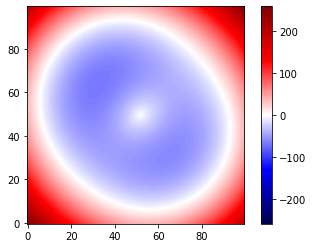

In [6]:
extreme = np.max(np.abs(t_days))
im = plt.imshow(t_days, origin="lower", vmin=-extreme, vmax=extreme, cmap="seismic")
plt.colorbar(im)
plt.show()

# Multiplane time delay image two planes

In [7]:
lens_model_list_mp = ["SIE", "SIE"]
redshift_list = [0.5, 0.1]
kwargs_lens = [
    {"theta_E": 1.1, "e1": 0.1, "e2": 0.1, "center_x": 0.1, "center_y": 0},
    {"theta_E": 1.1, "e1": 0.1, "e2": 0.1, "center_x": 0.0, "center_y": -0.3},
]

# from lenstronomy.LensModel import MultiPlane
MP = LensModel(
    z_source=z_source,
    lens_model_list=lens_model_list_mp,
    lens_redshift_list=redshift_list,
    cosmo=cosmo,
    multi_plane=True,
)
x_image, y_image = np.meshgrid(
    np.linspace(-numPix * deltaPix / 2, numPix * deltaPix / 2, numPix),
    np.linspace(-numPix * deltaPix / 2, numPix * deltaPix / 2, numPix),
)
t_days = MP.arrival_time(x_image, y_image, kwargs_lens)

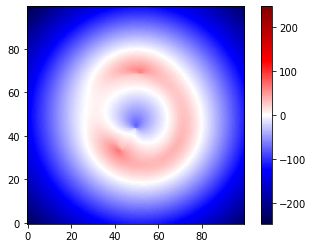

In [8]:
extreme = np.max(np.abs(t_days))
im = plt.imshow(t_days, origin="lower", vmin=-extreme, vmax=extreme, cmap="seismic")
plt.colorbar(im)
plt.show()

# Multiplane time delay image 5 planes

In [9]:
N = 5
lens_model_list_mp = ["SIE"] * N
redshift_list = np.linspace(0.1, 1.9, N)
lensModel = LensModel(
    lens_model_list=lens_model_list_mp,
    z_source=2,
    lens_redshift_list=redshift_list,
    multi_plane=True,
)

complex_ellipticity = list(
    param_util.phi_q2_ellipticity(phi=0.2 + 0.2 * i, q=0.3 + 0.1 * i) for i in range(N)
)
kwargs_lens = list(
    {
        "theta_E": 0.5,
        "e1": complex_ellipticity[i][0],
        "e2": complex_ellipticity[i][1],
        "center_x": 0.0,
        "center_y": 0.5 - 0.1 * i,
    }
    for i in range(N)
)
t_days = lensModel.arrival_time(x_image, y_image, kwargs_lens)

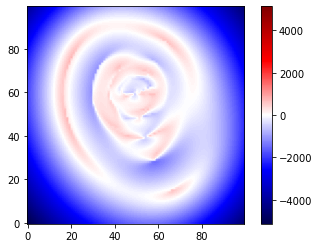

In [10]:
extreme = np.max(np.abs(t_days))
im = plt.imshow(t_days, origin="lower", vmin=-extreme, vmax=extreme, cmap="seismic")
plt.colorbar(im)
plt.show()

# Multiplane time delay image 10 planes

In [11]:
N = 10
lens_model_list_mp = ["SIE"] * N
redshift_list = np.linspace(0.1, 1.9, N)
lensModel = LensModel(
    lens_model_list=lens_model_list_mp,
    z_source=2,
    lens_redshift_list=redshift_list,
    multi_plane=True,
)
kwargs_lens = list(
    {
        "theta_E": 0.1 + 0.05 * i,
        "e1": 0.1,
        "e2": 0.1,
        "center_x": -0.5 + 0.1 * i,
        "center_y": 0.5 - 0.1 * i,
    }
    for i in range(N)
)
t_days = lensModel.arrival_time(x_image, y_image, kwargs_lens)

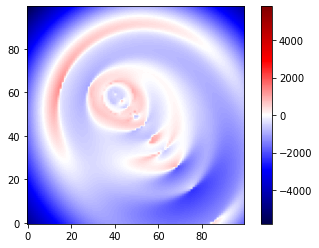

In [12]:
extreme = np.max(np.abs(t_days))
im = plt.imshow(t_days, origin="lower", vmin=-extreme, vmax=extreme, cmap="seismic")
plt.colorbar(im)
plt.show()